## Exotic grass mapping project: Script for exploratory data analysis of NDVI among exotic grass polygons for summer 2019

In [1]:
import numpy as np
import datetime as dt
import pandas as pd
import xarray as xr
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import requests
import os
import dask
import rasterio
import time
import geopandas as gpd
from rasterio import features
from rasterio import transform
import urllib.request
from dask.distributed import Client
from dask.distributed import wait, progress
import holoviews as hv
import geoviews as gv
import hvplot.xarray
import hvplot.pandas
import shapely
from urllib.request import urlopen
from zipfile import ZipFile
import requests
from io import BytesIO
import shapefile
from shapely.geometry import shape
from numba import jit
from urllib.error import HTTPError
from itertools import product
%matplotlib inline

In [2]:
landsat_proj = 'epsg:32613'

In [3]:
#fire up local dask cluster
client = Client()

In [4]:
client

<Client: 'tcp://127.0.0.1:61878' processes=4 threads=8, memory=34.02 GB>

## Exploratory data analysis

In [5]:
#Load previously saved hdf file
all_grasses_df = pd.read_hdf('../Data/grass_data_TOAreflectance.h5', key='df', mode = 'r')
df = all_grasses_df.reset_index().sort_values(by = 'time')
df = df[df['cloud_cvr'] <= 30] #Only keep images with cloud cover less than 30%

In [6]:
grass_types = ['Johnsongrass', 'Buffelgrass', 'Lehmanns', 'NA']

In [7]:
#Load in precipitation data
weather = pd.read_csv('../Data/PJNT2018_19.csv') #2019 data downloaded from MesoWest PJNT station
weather['Date_Time'] = pd.to_datetime(weather['Date_Time'])
weather['precip'] = weather['precip_accum_set_1'].diff()

C:\Users\kabbott\AppData\Local\ESRI\conda\envs\jupyter_gis\lib\site-packages\dateutil\parser\_parser.py:1218: UnknownTimezoneWarning: tzname CST identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)
C:\Users\kabbott\AppData\Local\ESRI\conda\envs\jupyter_gis\lib\site-packages\dateutil\parser\_parser.py:1218: UnknownTimezoneWarning: tzname CDT identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)


In [8]:
#Drop NA values, resample on daily basis, sum precipitation and remove first (spurious) date
weather = weather.dropna().resample('D', on = 'Date_Time').agg({'air_temp_set_1': ['max','min'], 'precip': 'sum'}).iloc[1:]
weather.columns = ['temp_max', 'temp_min', 'daily_precip']

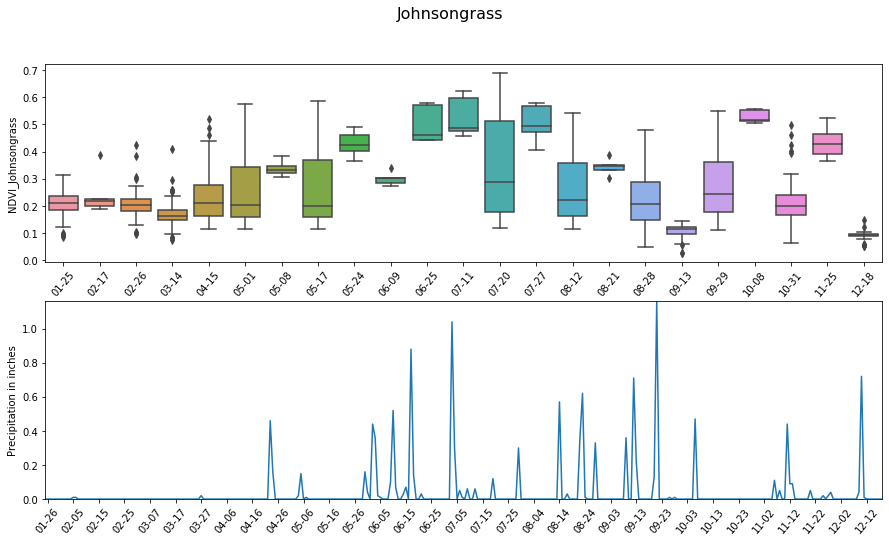

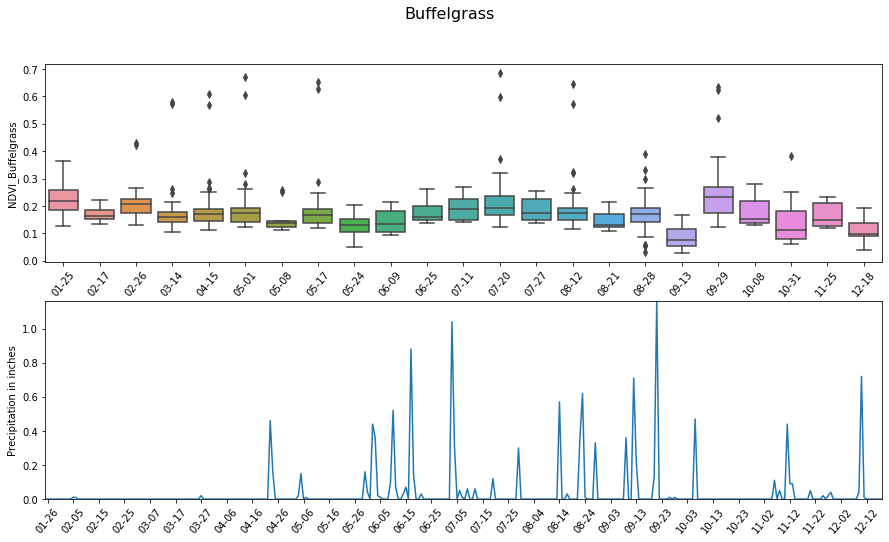

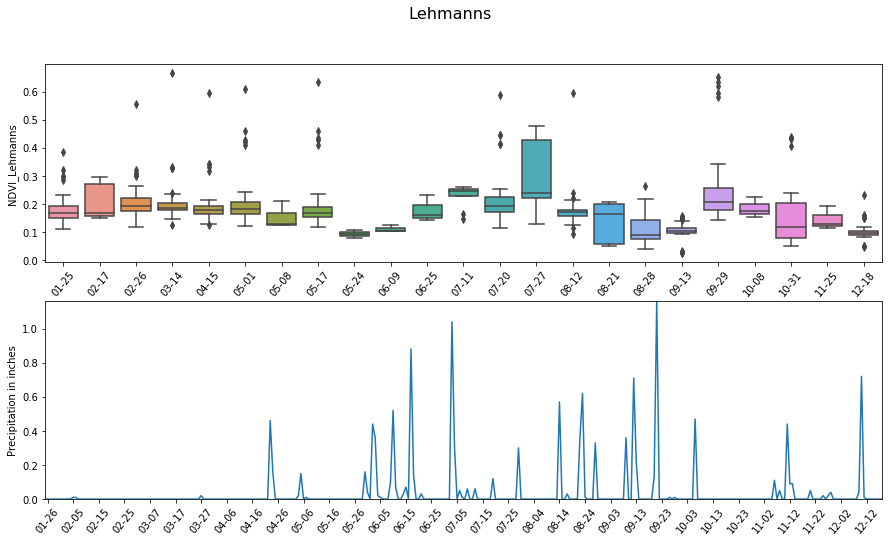

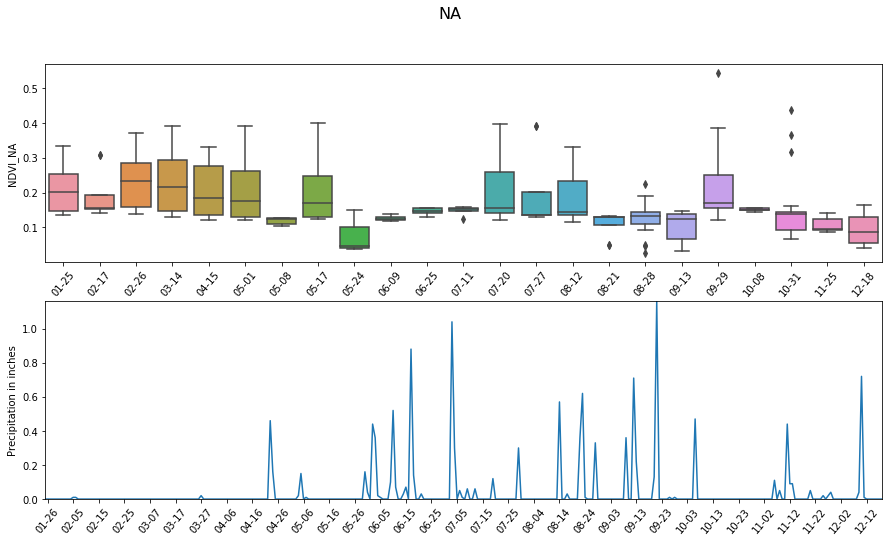

In [9]:
#Box plots of NDVI and precipitation for each date
for grass in grass_types:
    temp_df = df[~np.isnan(df[f'NDVI_{grass}'])]
    fig, ax = plt.subplots(2, figsize=(15,8))
    g = sns.boxplot(x = 'time', y = f'NDVI_{grass}', data = temp_df, ax = ax[0])
    # assign locator and formatter for the xaxis ticks.
    # get current xtick labels
    xticks = temp_df['time'].unique()
    # convert all xtick labels to selected format from ms timestamp
    date_labels = ax[0].set_xticklabels([pd.to_datetime(tm, unit='D').strftime('%m-%d') for tm in xticks], rotation=50)
    ax[1].plot(weather.index, weather['daily_precip'])
    ax[1].set_xlim([temp_df['time'].min(), temp_df['time'].max()])
    ax[1].set_ylim([0, weather['daily_precip'][weather.index.year > 2018].max()])
    ax[1].set_ylabel('Precipitation in inches')
    myFmt = mdates.DateFormatter('%m-%d')
    ax[1].xaxis.set_major_formatter(myFmt)
    ax[1].xaxis.set_major_locator(mdates.DayLocator(interval = 10))
    plt.sca(ax[1])
    plt.xticks(rotation=50)
    fig.suptitle(f'{grass}', fontsize = 16)
    #plt.savefig(f"{grass}_figure.png")

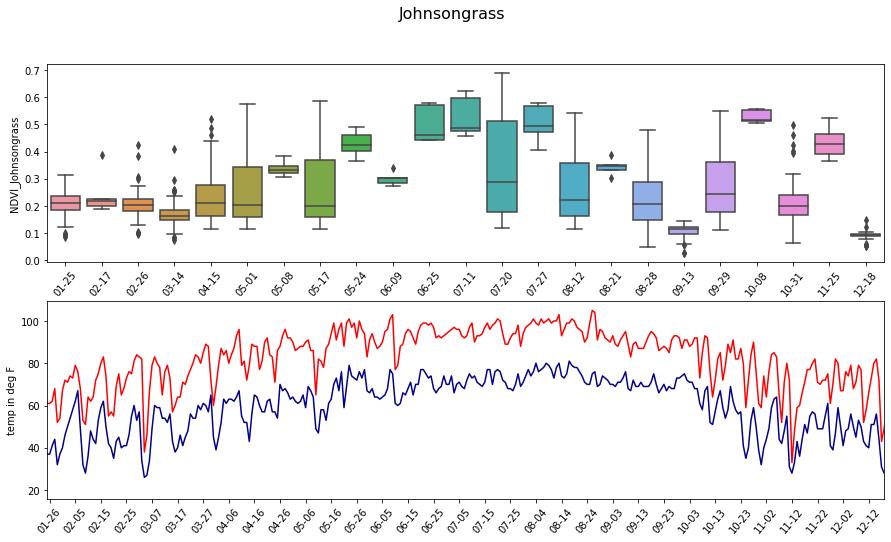

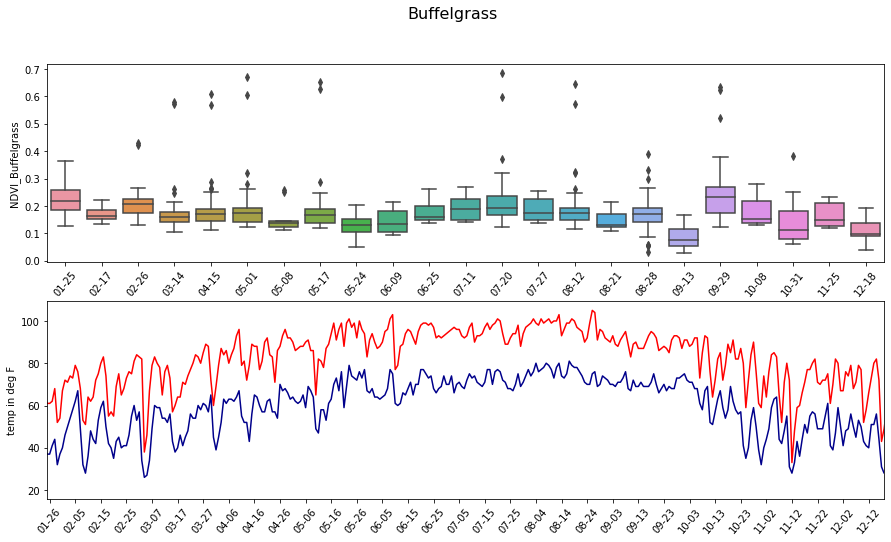

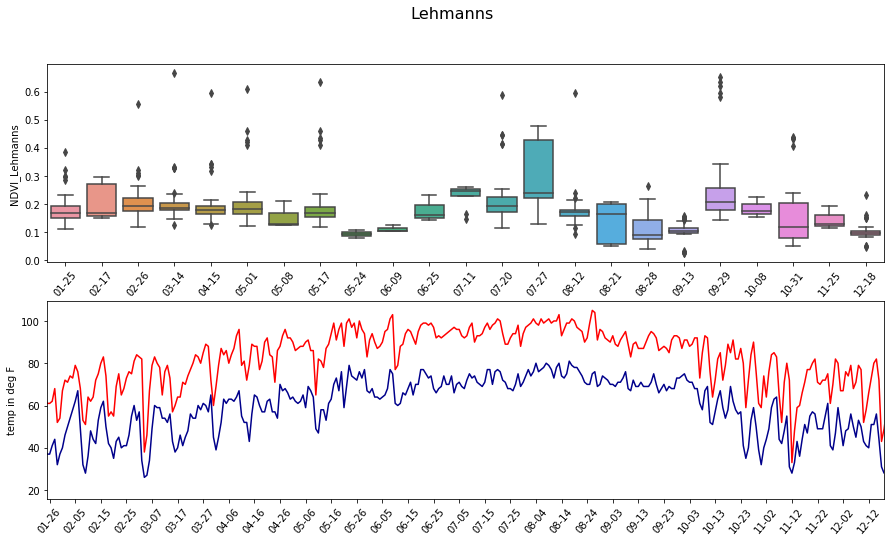

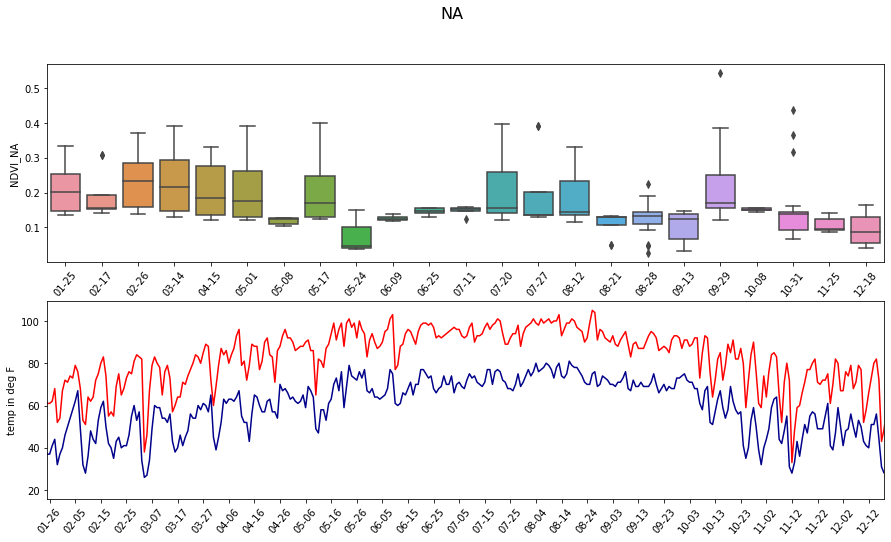

In [10]:
#Box plots of NDVI and precipitation for each date
for grass in grass_types:
    temp_df = df[~np.isnan(df[f'NDVI_{grass}'])]
    fig, ax = plt.subplots(2, figsize=(15,8))
    g = sns.boxplot(x = 'time', y = f'NDVI_{grass}', data = temp_df, ax = ax[0])
    # assign locator and formatter for the xaxis ticks.
    # get current xtick labels
    xticks = temp_df['time'].unique()
    # convert all xtick labels to selected format from ms timestamp
    date_labels = ax[0].set_xticklabels([pd.to_datetime(tm, unit='D').strftime('%m-%d') for tm in xticks], rotation=50)
    ax[1].plot(weather.index, weather['temp_min'], color = 'darkblue')
    ax[1].plot(weather.index, weather['temp_max'], color = 'red')
    ax[1].set_ylabel('temp in deg F')
    ax[1].set_xlim([temp_df['time'].min(), temp_df['time'].max()])
    myFmt = mdates.DateFormatter('%m-%d')
    ax[1].xaxis.set_major_formatter(myFmt)
    ax[1].xaxis.set_major_locator(mdates.DayLocator(interval = 10))
    plt.sca(ax[1])
    plt.xticks(rotation=50)
    fig.suptitle(f'{grass}', fontsize = 16)
    #plt.savefig(f"{grass}_figure.png")

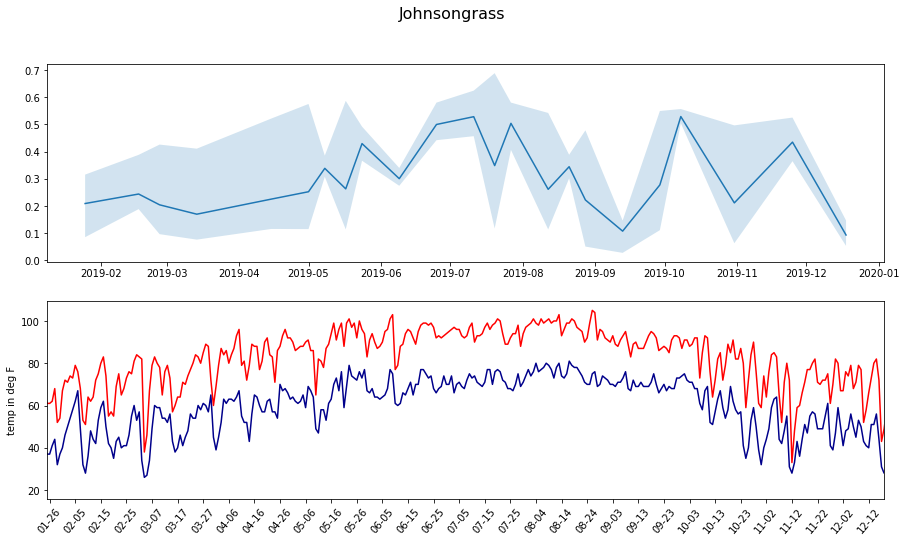

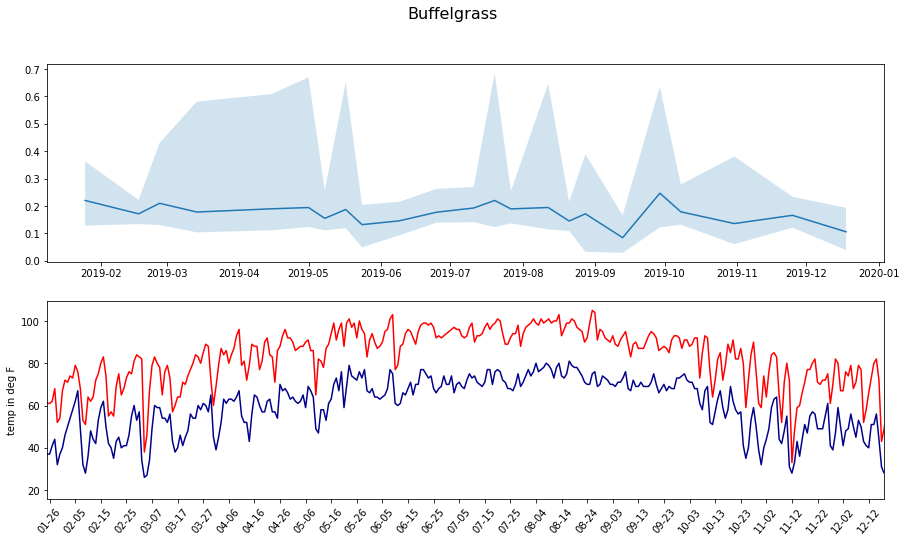

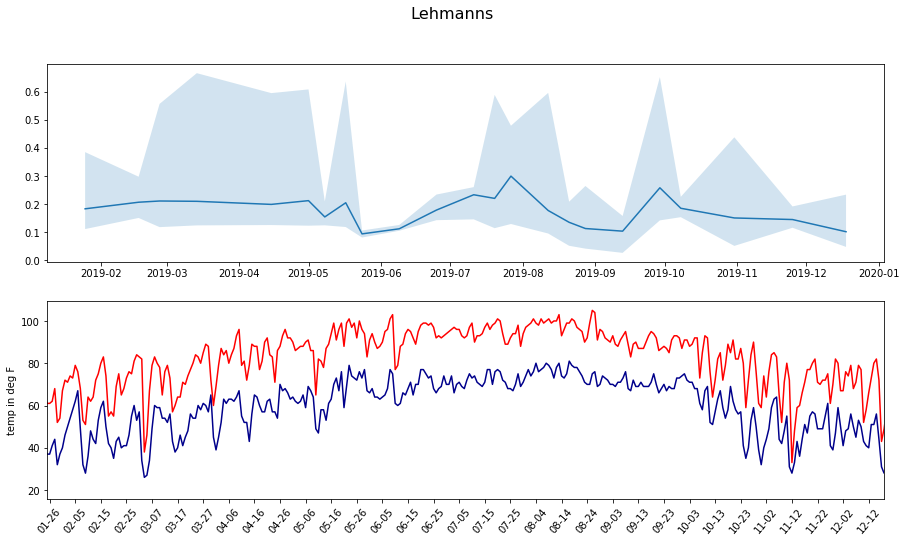

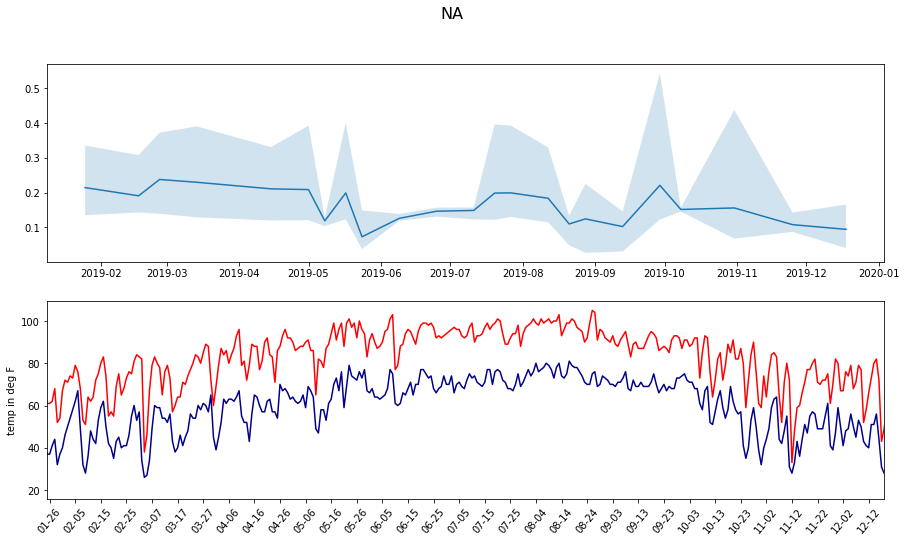

In [11]:
#Box plots of NDVI and precipitation for each date
for grass in grass_types:
    temp_df = df[~np.isnan(df[f'NDVI_{grass}'])]
    fig, ax = plt.subplots(2, figsize=(15,8))
    dff = temp_df.groupby('time').agg({f'NDVI_{grass}': ['mean', 'min', 'max']})
    dff.columns = ['mean', 'min', 'max']
    ax[0].plot(dff.index, dff['mean'], '-')
    ax[0].fill_between(dff.index, dff['min'], dff['max'], alpha=0.2)
    myFmt = mdates.DateFormatter('%m-%d')
    # assign locator and formatter for the xaxis ticks.
    # get current xtick labels
    xticks = dff.index
    # convert all xtick labels to selected format from ms timestamp
    #ax[0].xaxis.set_major_locator(mdates.DayLocator(interval = 10))
    #date_labels = ax[0].set_xticklabels([pd.to_datetime(tm, unit='D').strftime('%m-%d') for tm in xticks], rotation=50)
    ax[1].plot(weather.index, weather['temp_min'], color = 'darkblue')
    ax[1].plot(weather.index, weather['temp_max'], color = 'red')
    ax[1].set_ylabel('temp in deg F')
    ax[1].set_xlim([temp_df['time'].min(), temp_df['time'].max()])
    ax[1].xaxis.set_major_formatter(myFmt)
    ax[1].xaxis.set_major_locator(mdates.DayLocator(interval = 10))
    plt.sca(ax[1])
    plt.xticks(rotation=50)
    fig.suptitle(f'{grass}', fontsize = 16)
    #plt.savefig(f"{grass}_figure.png")

In [12]:
xticks

DatetimeIndex(['2019-01-25', '2019-02-17', '2019-02-26', '2019-03-14',
               '2019-04-15', '2019-05-01', '2019-05-08', '2019-05-17',
               '2019-05-24', '2019-06-09', '2019-06-25', '2019-07-11',
               '2019-07-20', '2019-07-27', '2019-08-12', '2019-08-21',
               '2019-08-28', '2019-09-13', '2019-09-29', '2019-10-08',
               '2019-10-31', '2019-11-25', '2019-12-18'],
              dtype='datetime64[ns]', name='time', freq=None)

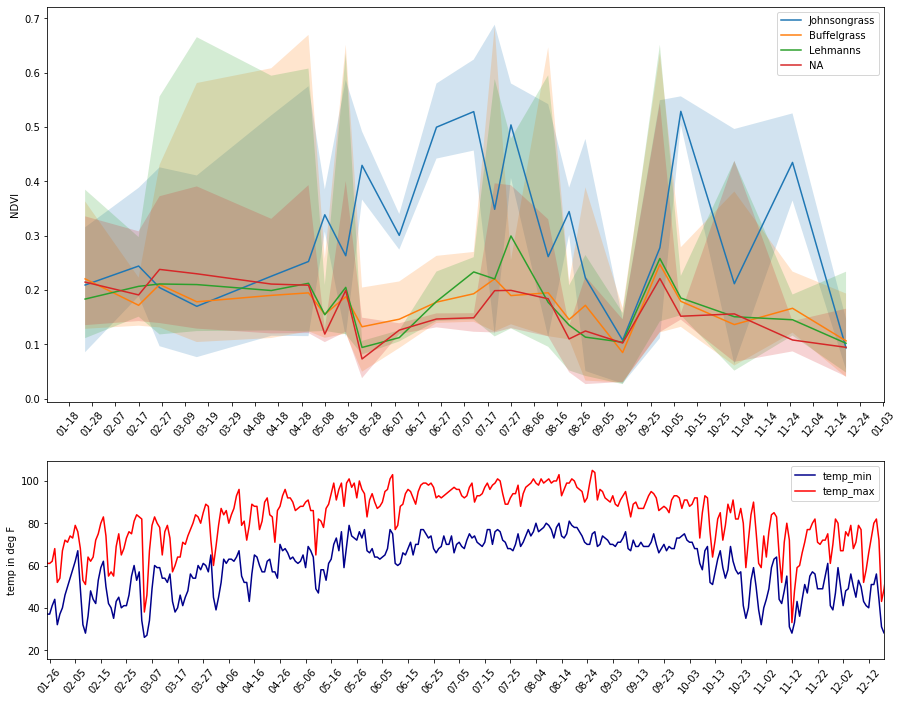

In [13]:
fig, ax = plt.subplots(2, 1, figsize=(15,12), gridspec_kw={'height_ratios': [2, 1]})
for grass in grass_types:
    temp_df = df[~np.isnan(df[f'NDVI_{grass}'])]
    dff = temp_df.groupby('time').agg({f'NDVI_{grass}': ['mean', 'min', 'max']})
    dff.columns = ['mean', 'min', 'max']
    ax[0].plot(dff.index, dff['mean'], '-', label = grass)
    ax[0].fill_between(dff.index, dff['min'], dff['max'], alpha=0.2)
    myFmt = mdates.DateFormatter('%m-%d')
    # assign locator and formatter for the xaxis ticks.
    # get current xtick labels
    xticks = dff.index
    # convert all xtick labels to selected format from ms timestamp
    ax[0].xaxis.set_major_formatter(myFmt)
    ax[0].xaxis.set_major_locator(mdates.DayLocator(interval = 10))
    #date_labels = ax[0].set_xticklabels([pd.to_datetime(tm, unit='D').strftime('%m-%d') for tm in xticks], rotation=50)
    #plt.savefig(f"{grass}_figure.png")
ax[1].plot(weather.index, weather['temp_min'], color = 'darkblue', label = 'temp_min')
ax[1].plot(weather.index, weather['temp_max'], color = 'red', label = 'temp_max')
ax[1].set_ylabel('temp in deg F')
ax[1].set_xlim([temp_df['time'].min(), temp_df['time'].max()])
ax[1].xaxis.set_major_formatter(myFmt)
ax[1].xaxis.set_major_locator(mdates.DayLocator(interval = 10))
ax[0].set_ylabel('NDVI')
plt.sca(ax[1])
plt.xticks(rotation=50)
plt.sca(ax[0])
plt.xticks(rotation=50)
ax[0].legend()
ax[1].legend()
plt.savefig('2019_seasonal_NDVI.png', dpi = 500)

C:\Users\kabbott\AppData\Local\ESRI\conda\envs\jupyter_gis\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\kabbott\AppData\Local\ESRI\conda\envs\jupyter_gis\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """


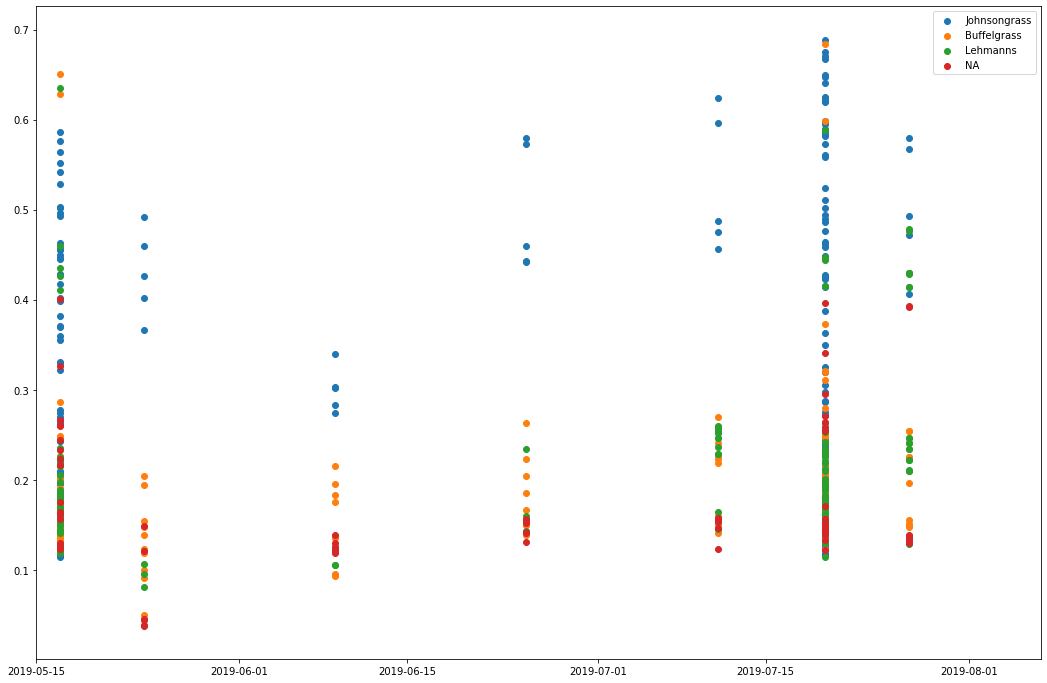

In [14]:
df_summer = df[(df['time'] >= '2019-05-17') & (df['time'] <= '2019-08-05')]
df_summer['time'] = pd.to_datetime(df_summer['time'])
fig = plt.figure(figsize = (18,12))
for grass in grass_types:
    temp_df = df_summer[~np.isnan(df[f'NDVI_{grass}'])]
    plt.scatter(temp_df['time'],temp_df[f'NDVI_{grass}'], label = grass)
    plt.xlim(dt.datetime(2019,5,15), dt.datetime(2019, 8, 7))
plt.legend()

## EDA: Identifying possible summer Johnsongrass thresholds

In [15]:
all_grasses_df = pd.read_hdf('../Data/grass_data_TOAreflectance.h5', key='df', mode = 'r')
dff = all_grasses_df.reset_index().sort_values(by = 'time')
dff.loc[dff['cloud_cvr'] > 30, "NDVI_Johnsongrass"] = np.nan

In [16]:
df_summer = dff[(dff['time'] >= '2019-05-17') & (dff['time'] <= '2019-07-20')]
df_juneish = dff[(dff['time'] >= '2019-05-25') & (dff['time'] <= '2019-07-07')]

In [17]:
df_j = df_juneish[['lat', 'lon', 'time', 'NDVI_Johnsongrass']]
df_s = df_summer[['lat', 'lon', 'time', 'NDVI_Johnsongrass']]

In [18]:
print("Mean NDVI value over time period:", round(df_j['NDVI_Johnsongrass'].mean(),3))
print("Mean NDVI value minus 1 std over time period:", round(df_j['NDVI_Johnsongrass'].mean() - df_j['NDVI_Johnsongrass'].std(),3))

Mean NDVI value over time period: 0.4
Mean NDVI value minus 1 std over time period: 0.284


In [19]:
df_j.sort_values(by = 'time')

lat       lon       time  NDVI_Johnsongrass
1309   3219210.0  684030.0 2019-06-02                NaN
289    3214470.0  684420.0 2019-06-02                NaN
13294  3258450.0  680520.0 2019-06-02                NaN
10575  3255510.0  679950.0 2019-06-02                NaN
10574  3255510.0  679950.0 2019-06-02                NaN
...          ...       ...        ...                ...
11857  3258360.0  680550.0 2019-07-04                NaN
11858  3258360.0  680550.0 2019-07-04                NaN
12793  3258420.0  680460.0 2019-07-04                NaN
13727  3258480.0  680400.0 2019-07-04                NaN
2082   3226470.0  693960.0 2019-07-04                NaN

[2030 rows x 4 columns]

In [20]:
#Calculate average change per week
df_s['latlon'] = list(zip(df_s['lat'], df_s['lon']))
df_s1 = df_s.copy()
df_s1 = df_s1.sort_values(by='latlon')
df_s1['jg_shift'] = df_s1.groupby('latlon')['NDVI_Johnsongrass'].diff()
df_s1 = df_s1.dropna()
print("Average positive increase in NDVI between images:", round(df_s1[df_s1['jg_shift']>=0].jg_shift.mean(), 3))
print("Average increase in NDVI between images:", round(df_s1.jg_shift.mean(),3))

Average positive increase in NDVI between images: 0.072
Average increase in NDVI between images: -0.007


C:\Users\kabbott\AppData\Local\ESRI\conda\envs\jupyter_gis\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [21]:
print("Average difference between min and max per location:", np.nanmean(df_s.groupby('latlon')['NDVI_Johnsongrass'].apply(lambda x: max(x) - min(x))))

Average difference between min and max per location: 0.08876644566269973


### Analysis on precipitation and climate data frame

In [22]:
windows = [7, 14, 21, 28] #7,14, and 28 day rolling windows for averaging

In [23]:
for days in windows:
    weather[f'precip_{days}'] = weather['daily_precip'].rolling(days).sum()
    weather[f'temp_max_{days}'] = weather['temp_max'].rolling(days).mean()
    weather[f'temp_min_{days}'] = weather['temp_min'].rolling(days).mean()

In [24]:
rolling_columns = [f'precip_{days}' for days in windows] + [f'temp_max_{days}' for days in windows] + [f'temp_min_{days}' for days in windows]

## Grass-specific analysis: 
### Lehmann's

In [25]:
#For convenience, isolate dataframe that contains Lehmanns NDVI data
grass = 'Lehmanns'
df1 = df[~np.isnan(df[f'NDVI_{grass}'])]

In [26]:
#Get min max and mean for NDVI calculations
df2 = df1.groupby(by = 'time').agg({f'NDVI_{grass}': ['min', 'max', 'mean']})
df2.columns = ['NDVI_min', 'NDVI_max', 'NDVI_mean']

In [27]:
#Link precipitation and climate data
df2 = df2.merge(weather[rolling_columns], how='left', left_on='time', right_index=True)

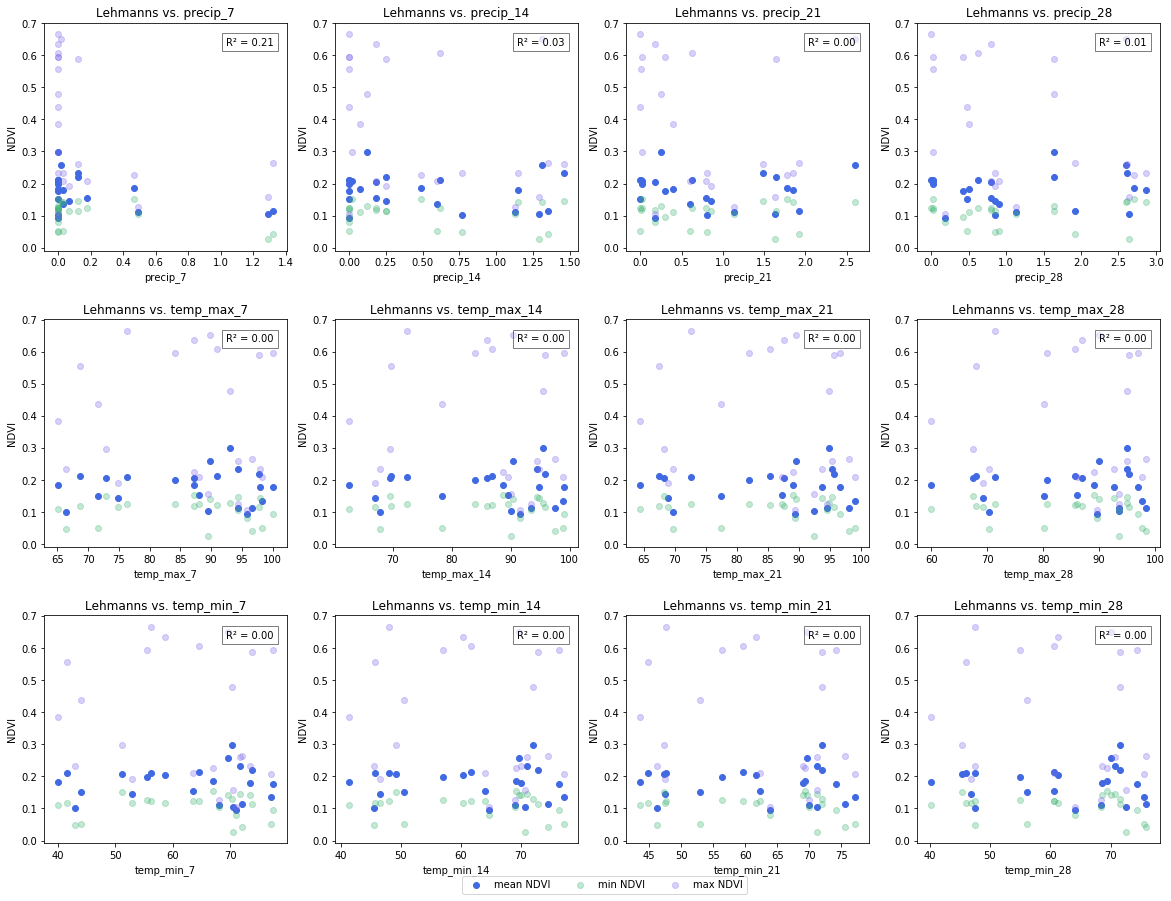

In [28]:
#Plot precipitation and temperature data against NDVI data.
fig, axes = plt.subplots(3,4, figsize=(20,15))
axes_flat = axes.flatten()
i = 0
for name in rolling_columns:
    ax = axes_flat[i]
    ax.scatter(df2[name], df2['NDVI_mean'], color='royalblue', label='mean NDVI')
    r_squared = df2[name].corr(df2['NDVI_mean'])**2
    ax.text(0.75, .9, f'R\u00b2 = {r_squared:.2f}', transform=ax.transAxes, bbox=dict(facecolor='white', alpha=0.5))
    ax.scatter(df2[name], df2['NDVI_min'], color='mediumseagreen', alpha=0.3, label='min NDVI')
    ax.scatter(df2[name], df2['NDVI_max'], color='mediumslateblue', alpha=0.3, label='max NDVI')
    ax.set_title(f'{grass} vs. {name}')
    ax.set_xlabel(name)
    ax.set_ylabel('NDVI')
    i +=1
plt.subplots_adjust(hspace=0.3, bottom=0.12)
axes_flat[-3].legend(loc='upper left', bbox_to_anchor=(0.5,-0.12), ncol = 3)

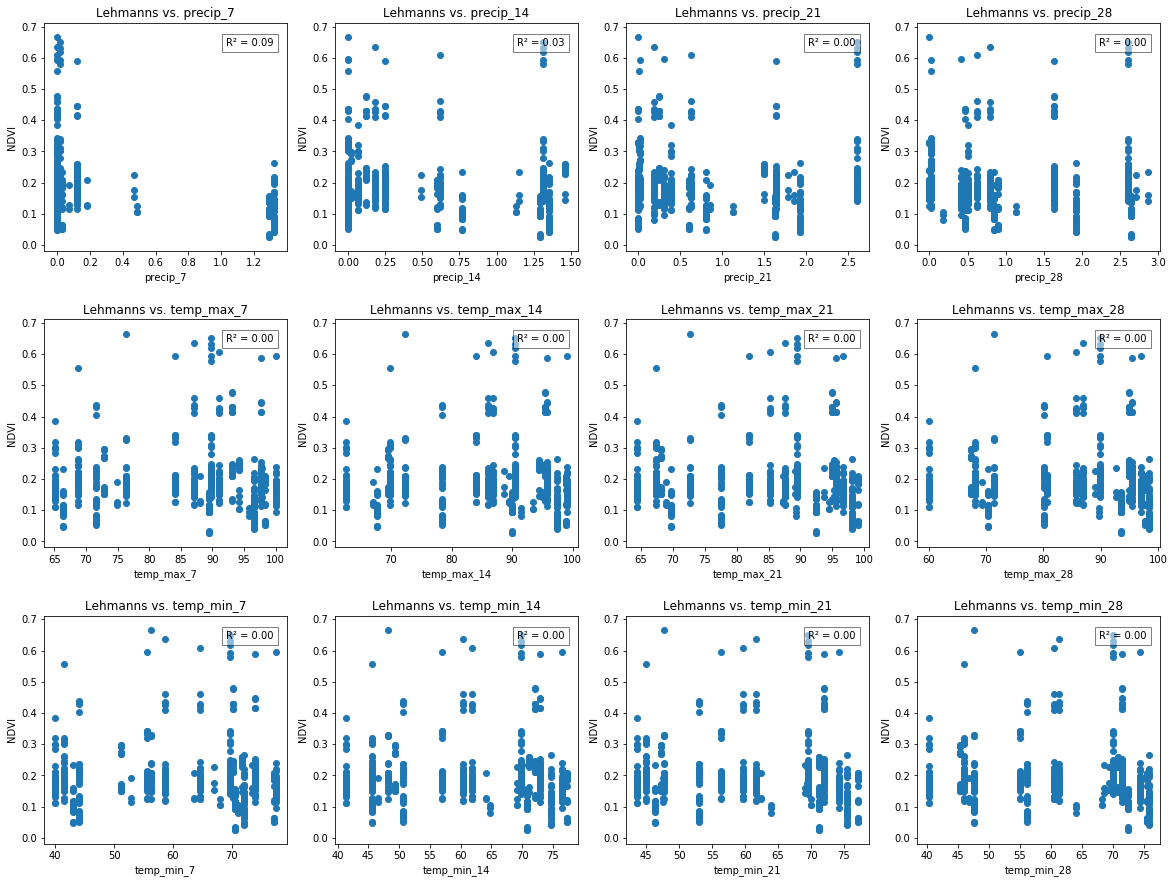

In [29]:
#Simply show scatter plots, no means or aggregation done on NDVI data
df3 = df1.merge(weather[rolling_columns], how = 'left', left_on = 'time', right_index = True)
fig, axes = plt.subplots(3,4, figsize=(20,15))
axes_flat = axes.flatten()
i = 0
for name in rolling_columns:
    ax = axes_flat[i]
    ax.scatter(df3[name], df3[f'NDVI_{grass}'])
    r_squared = df3[name].corr(df3[f'NDVI_{grass}'])**2
    ax.text(0.75, .9, f'R\u00b2 = {r_squared:.2f}', transform=ax.transAxes, bbox=dict(facecolor='white', alpha=0.5))
    ax.set_title(f'{grass} vs. {name}')
    ax.set_xlabel(name)
    ax.set_ylabel('NDVI')
    i += 1
plt.subplots_adjust(hspace=0.3, bottom=0.12)

## Johnsongrass 

In [30]:
#For convenience, isolate dataframe that contains Johnsongrass NDVI data
grass = 'Johnsongrass'
df1 = df[~np.isnan(df[f'NDVI_{grass}'])]

In [31]:
#Get min max and mean for NDVI calculations
df2 = df1.groupby(by = 'time').agg({f'NDVI_{grass}': ['min', 'max', 'mean']})
df2.columns = ['NDVI_min', 'NDVI_max', 'NDVI_mean']

In [32]:
#Link precipitation and climate data
df2 = df2.merge(weather[rolling_columns], how='left', left_on='time', right_index=True)

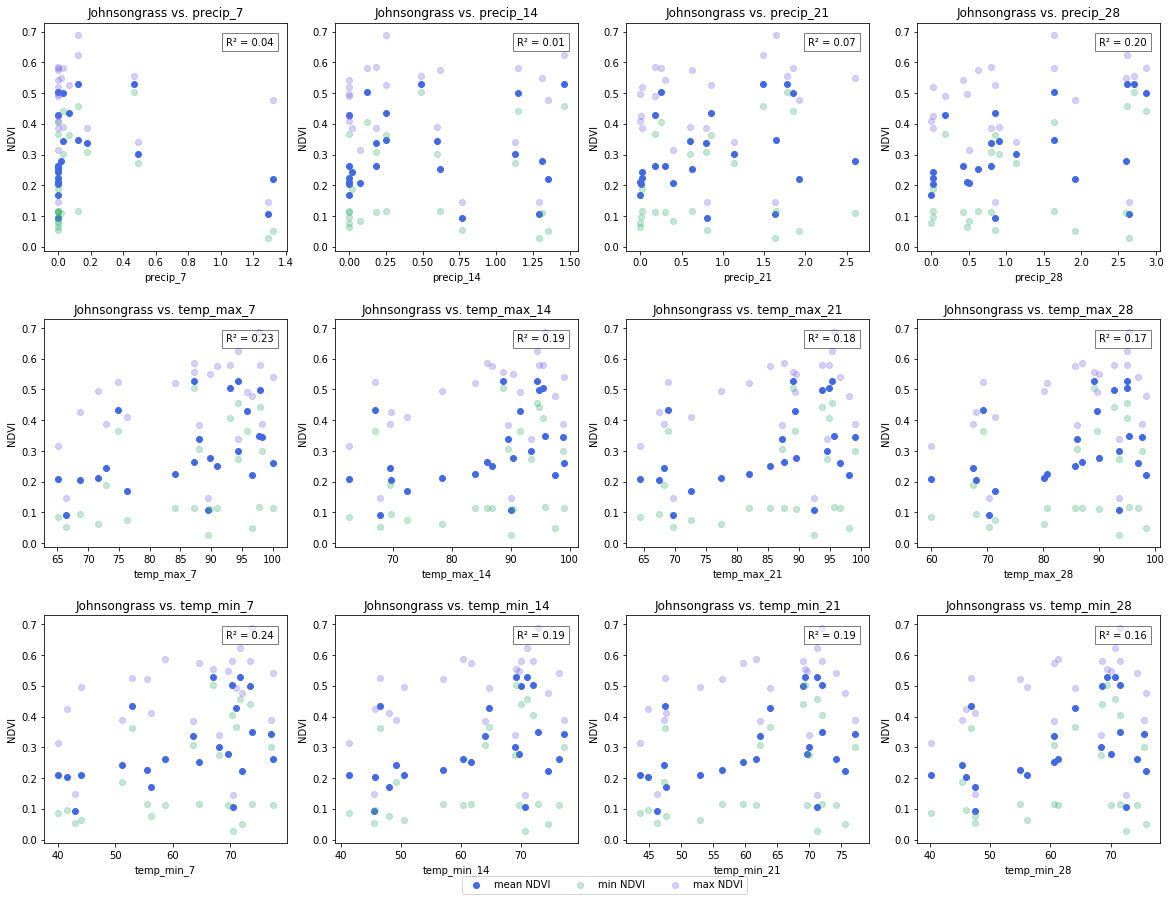

In [34]:
#Plot precipitation and temperature data against NDVI data.
fig, axes = plt.subplots(3,4, figsize=(20,15))
axes_flat = axes.flatten()
i = 0
for name in rolling_columns:
    ax = axes_flat[i]
    ax.scatter(df2[name], df2['NDVI_mean'], color='royalblue', label='mean NDVI')
    r_squared = df2[name].corr(df2['NDVI_mean'])**2
    ax.text(0.75, .9, f'R\u00b2 = {r_squared:.2f}', transform=ax.transAxes, bbox=dict(facecolor='white', alpha=0.5))
    ax.scatter(df2[name], df2['NDVI_min'], color='mediumseagreen', alpha=0.3, label='min NDVI')
    ax.scatter(df2[name], df2['NDVI_max'], color='mediumslateblue', alpha=0.3, label='max NDVI')
    ax.set_title(f'{grass} vs. {name}')
    ax.set_xlabel(name)
    ax.set_ylabel('NDVI')
    i +=1
plt.subplots_adjust(hspace=0.3, bottom=0.12)
axes_flat[-3].legend(loc='upper left', bbox_to_anchor=(0.5,-0.12), ncol = 3)
plt.savefig('../images/Johnsongrass_climatecorr.png', dpi = 300)

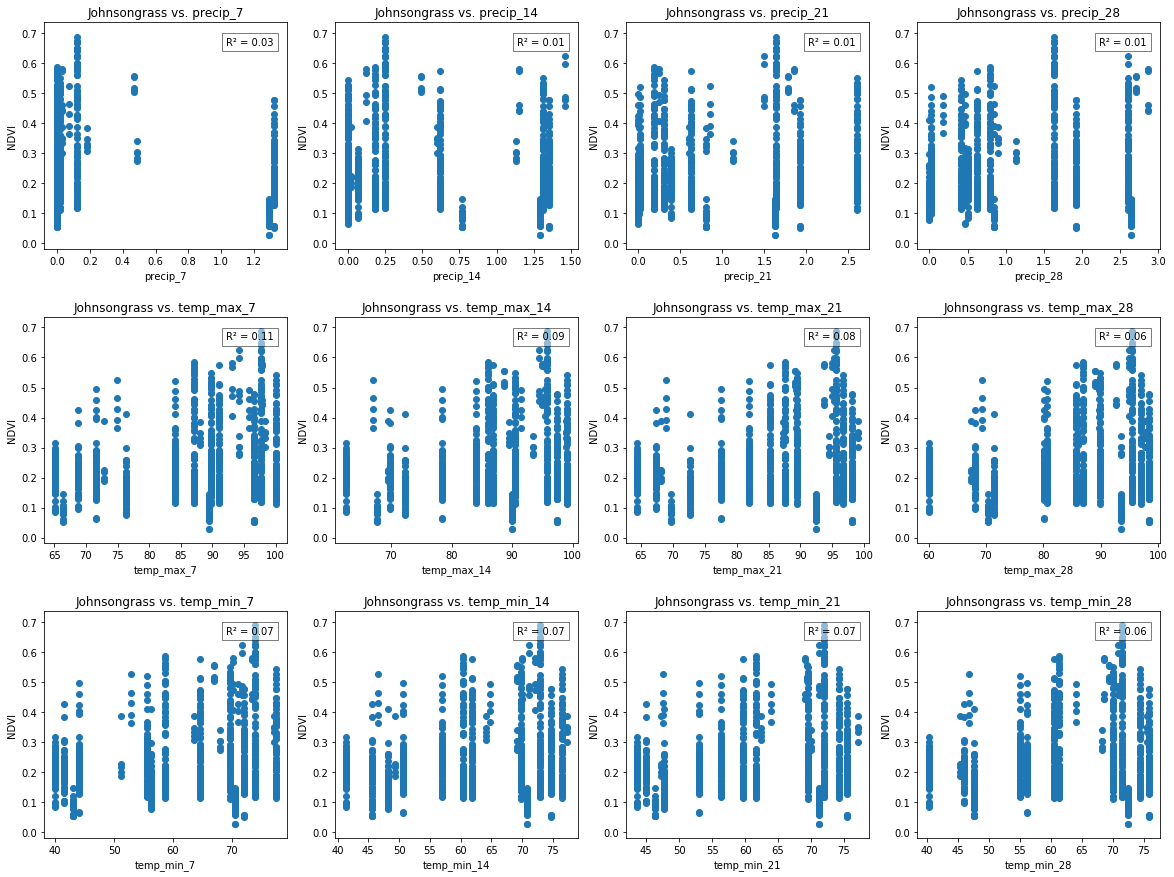

In [34]:
#Simply show scatter plots, no means or aggregation done on NDVI data
df3 = df1.merge(weather[rolling_columns], how = 'left', left_on = 'time', right_index = True)
fig, axes = plt.subplots(3,4, figsize=(20,15))
axes_flat = axes.flatten()
i = 0
for name in rolling_columns:
    ax = axes_flat[i]
    ax.scatter(df3[name], df3[f'NDVI_{grass}'])
    r_squared = df3[name].corr(df3[f'NDVI_{grass}'])**2
    ax.text(0.75, .9, f'R\u00b2 = {r_squared:.2f}', transform=ax.transAxes, bbox=dict(facecolor='white', alpha=0.5))
    ax.set_title(f'{grass} vs. {name}')
    ax.set_xlabel(name)
    ax.set_ylabel('NDVI')
    i += 1
plt.subplots_adjust(hspace=0.3)

## Buffelgrass 

In [35]:
#For convenience, isolate dataframe that contains Buffelgrass NDVI data
grass = 'Buffelgrass'
df1 = df[~np.isnan(df[f'NDVI_{grass}'])]

In [36]:
#Get min max and mean for NDVI calculations
df2 = df1.groupby(by = 'time').agg({f'NDVI_{grass}': ['min', 'max', 'mean']})
df2.columns = ['NDVI_min', 'NDVI_max', 'NDVI_mean']

In [37]:
#Link precipitation and climate data
df2 = df2.merge(weather[rolling_columns], how='left', left_on='time', right_index=True)

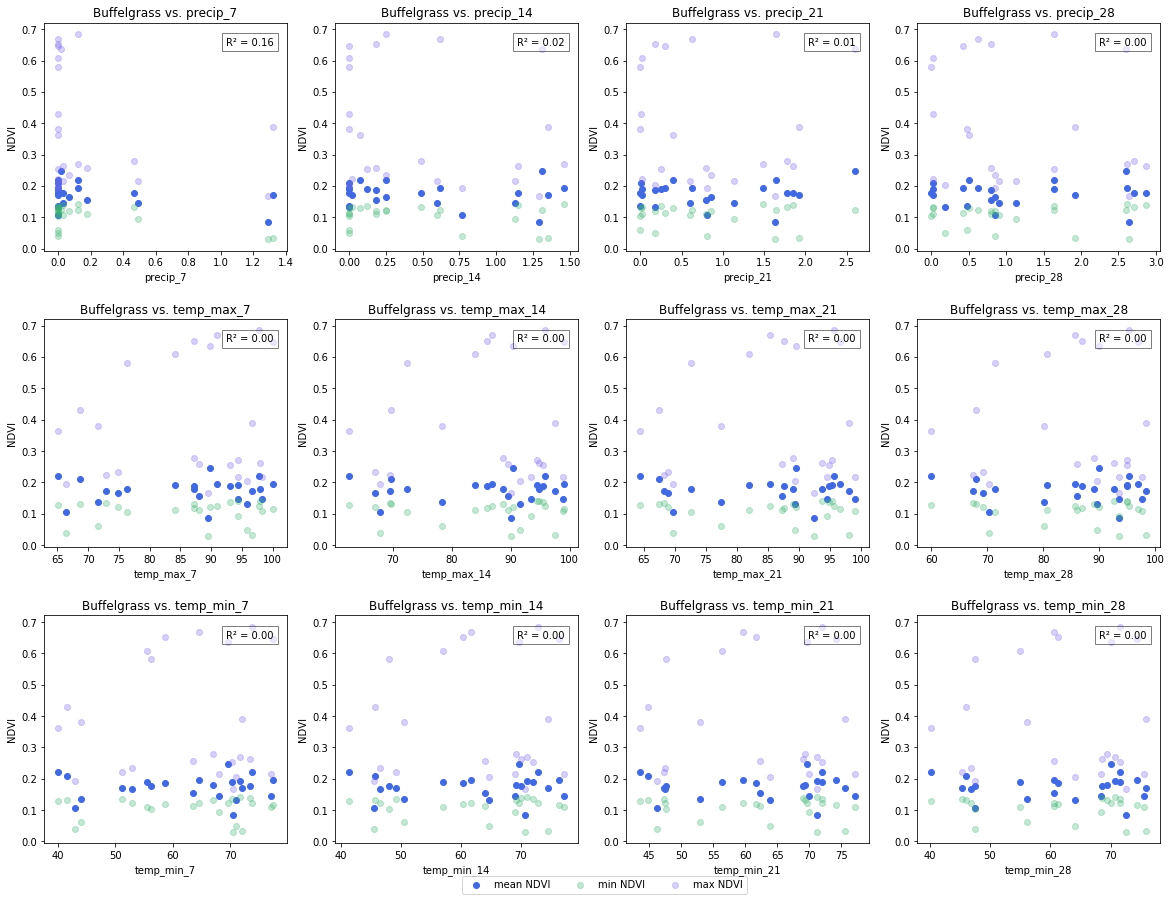

In [38]:
#Plot precipitation and temperature data against NDVI data.
fig, axes = plt.subplots(3,4, figsize=(20,15))
axes_flat = axes.flatten()
i = 0
for name in rolling_columns:
    ax = axes_flat[i]
    ax.scatter(df2[name], df2['NDVI_mean'], color='royalblue', label='mean NDVI')
    r_squared = df2[name].corr(df2['NDVI_mean'])**2
    ax.text(0.75, .9, f'R\u00b2 = {r_squared:.2f}', transform=ax.transAxes, bbox=dict(facecolor='white', alpha=0.5))
    ax.scatter(df2[name], df2['NDVI_min'], color='mediumseagreen', alpha=0.3, label='min NDVI')
    ax.scatter(df2[name], df2['NDVI_max'], color='mediumslateblue', alpha=0.3, label='max NDVI')
    ax.set_title(f'{grass} vs. {name}')
    ax.set_xlabel(name)
    ax.set_ylabel('NDVI')
    i +=1
plt.subplots_adjust(hspace=0.3, bottom=0.12)
axes_flat[-3].legend(loc='upper left', bbox_to_anchor=(0.5,-0.12), ncol = 3)

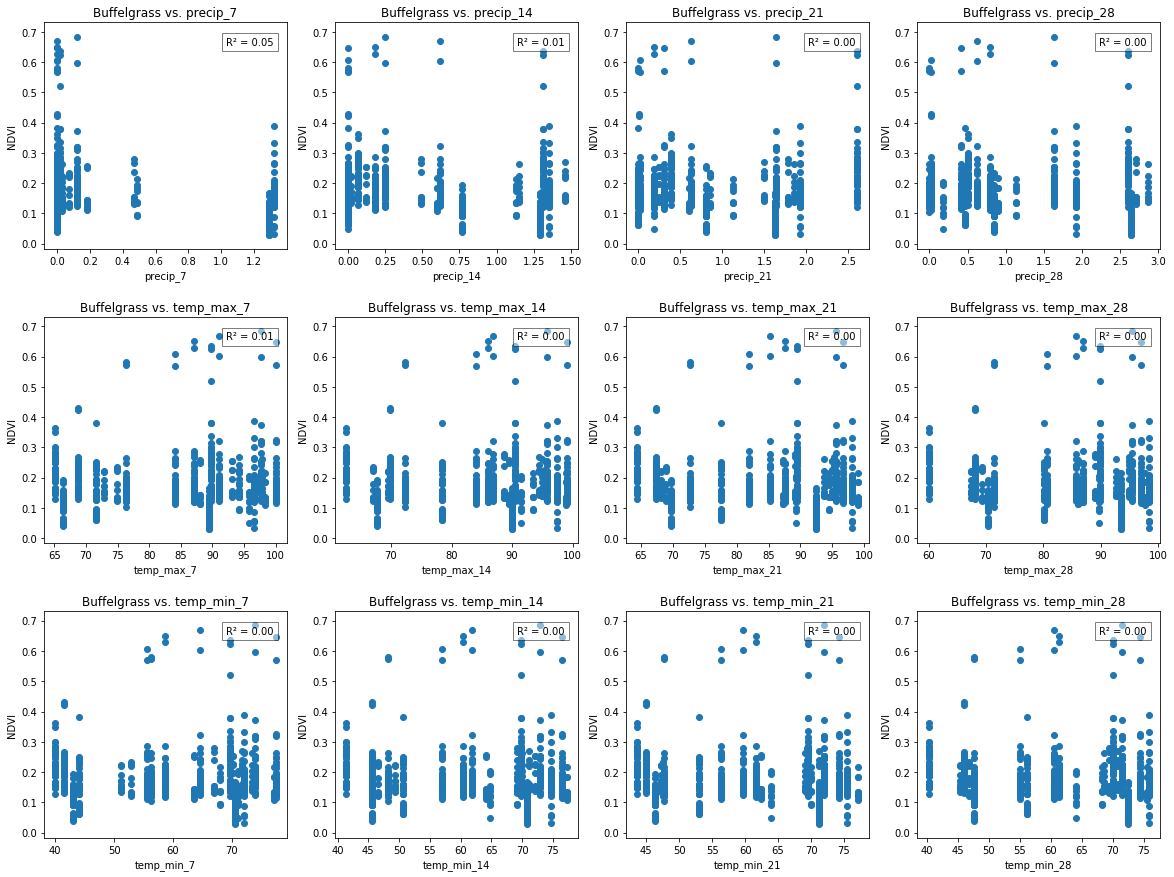

In [39]:
#Simply show scatter plots, no means or aggregation done on NDVI data
df3 = df1.merge(weather[rolling_columns], how = 'left', left_on = 'time', right_index = True)
fig, axes = plt.subplots(3,4, figsize=(20,15))
axes_flat = axes.flatten()
i = 0
for name in rolling_columns:
    ax = axes_flat[i]
    ax.scatter(df3[name], df3[f'NDVI_{grass}'])
    r_squared = df3[name].corr(df3[f'NDVI_{grass}'])**2
    ax.text(0.75, .9, f'R\u00b2 = {r_squared:.2f}', transform=ax.transAxes, bbox=dict(facecolor='white', alpha=0.5))
    ax.set_title(f'{grass} vs. {name}')
    ax.set_xlabel(name)
    ax.set_ylabel('NDVI')
    i += 1
plt.subplots_adjust(hspace=0.3)

### Playing around with cross-correlations and optimal lags for data

In [40]:
def cross_cor(grass_df, weather_df, column1, column2, lag=0):
    """Calculate correlation with varying lags between data
    column 1 refers to the column of interest in the grass dataframe (likely NDVI_{grass})
    column 2 refers to the column of interest in the weather dataframe, i.e daily_precip
    a lag of 1 refers to a correlation of grass data with weather data from 1 day before"""
    weather_df = weather_df.tshift(lag, freq='D')
    df = grass_df.merge(weather_df, how = 'left', left_on = 'time', right_index = True)
    return df[column1].corr(df[column2])

In [41]:
grass = 'Johnsongrass'
df1 = df[~np.isnan(df[f'NDVI_{grass}'])]

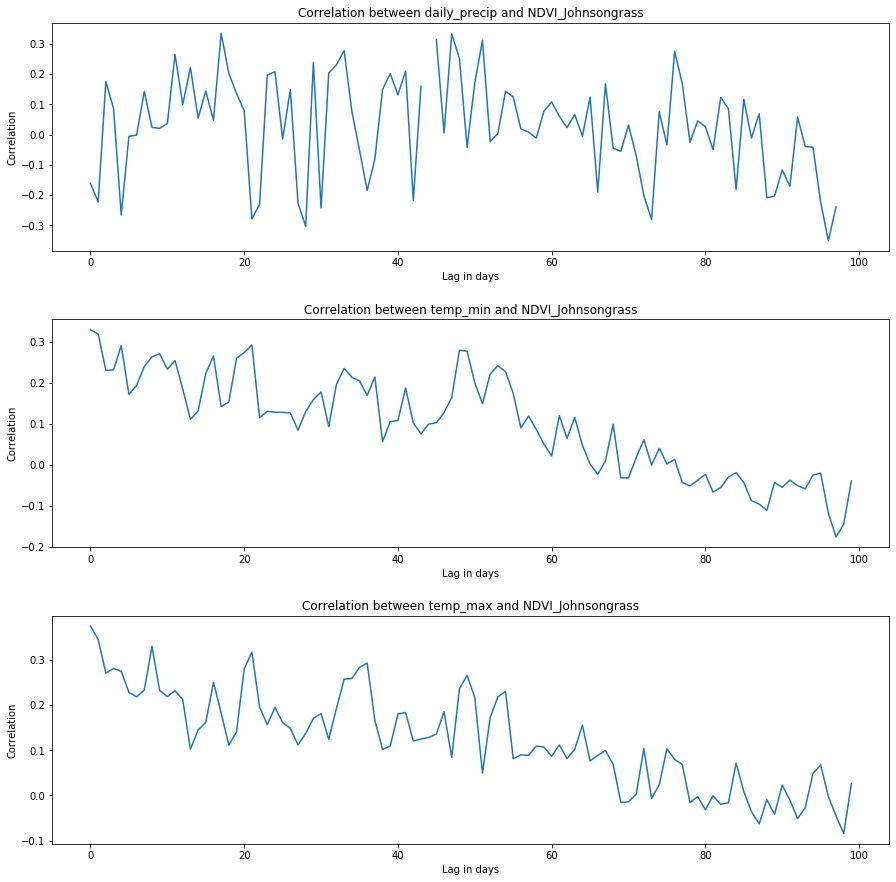

In [42]:
fig, axes = plt.subplots(3, figsize=(15,15))
for i, stat in enumerate(['daily_precip', 'temp_min', 'temp_max']):
    ax = axes[i]
    jg_xcor = [cross_cor(df1, weather, f'NDVI_{grass}', stat, lag = days) for days in range(100)]
    ax.plot(range(100), jg_xcor)
    ax.set_ylabel('Correlation')
    ax.set_xlabel('Lag in days')
    ax.set_title(f'Correlation between {stat} and NDVI_{grass}')
plt.subplots_adjust(hspace=0.3, bottom=0.12)

In [43]:
#Looking at correlations between independent/explanatory variables. No surprise that temps have high correlation with each other, 
#as do rolling averages. 
factors = list(weather.columns)
for factor in factors:
    factors_minus = factors.copy()
    factors_minus.remove(factor)
    for factor1 in factors_minus:
        print(f'Correlation between {factor} and {factor1} is {weather[factor].corr(weather[factor1])}')

Correlation between temp_max and temp_min is 0.913949737512462
Correlation between temp_max and daily_precip is -0.01090394950856486
Correlation between temp_max and precip_7 is 0.11128594922381159
Correlation between temp_max and temp_max_7 is 0.8628698472223313
Correlation between temp_max and temp_min_7 is 0.8194090046108703
Correlation between temp_max and precip_14 is 0.1890530899150265
Correlation between temp_max and temp_max_14 is 0.8337965673480049
Correlation between temp_max and temp_min_14 is 0.8013891481013581
Correlation between temp_max and precip_21 is 0.22824710798811532
Correlation between temp_max and temp_max_21 is 0.8153213577825194
Correlation between temp_max and temp_min_21 is 0.7792820678595539
Correlation between temp_max and precip_28 is 0.21509581087924243
Correlation between temp_max and temp_max_28 is 0.8060819501306624
Correlation between temp_max and temp_min_28 is 0.7592406830857886
Correlation between temp_min and temp_max is 0.9139497375124619
Correla

## Sandbox/scratch work

This was a space to try out different combinations and analyses that were never fully polished but may be useful down the line. 

In [39]:
DS = xr.open_zarr('../Data/2019_Landsat_masked.zarr')
grasses = gpd.read_file('../Data/BIBE_exotic_grass_gdf.geojson')

In [40]:
#Calculate affine transformation of DS (different than individual images)
latmin, latmax = float(DS.coords['lat'].min()), float(DS.coords['lat'].max())
lonmin, lonmax = float(DS.coords['lon'].min()), float(DS.coords['lon'].max())
DS_dims = (DS.dims['lat'], DS.dims['lon'])
transf = transform.from_bounds(lonmin, latmin, lonmax, latmax, 
                               DS_dims[1] - 1, DS_dims[0] - 1) #width, height are 1 less than columns, rows

In [41]:
#Generate all_touched mask (i.e. all pixels that touch the shape boundary)
shapes = ((geom, value) for geom, value in zip(grasses.geometry, grasses.ID))
burned_outer = np.flip(features.rasterize(shapes=shapes, out_shape=DS_dims,fill=0, all_touched=True, transform=transf), 0)

#Generate inner mask (i.e. only pixels enclosed in the shape boundary)
shapes = ((geom, value) for geom, value in zip(grasses.geometry, grasses.ID))
burned_inner = np.flip(features.rasterize(shapes=shapes, out_shape=DS_dims,fill=0, all_touched=False, transform=transf), 0)

In [42]:
burned_outer.shape

(2668, 3045)

In [43]:
np.count_nonzero(burned_inner)

44

In [44]:
DS.coords['lat'].values.shape

(2668,)

In [45]:
burned_inner.shape

(2668, 3045)

In [46]:
longrid, latgrid = np.meshgrid(DS.coords['lon'], DS.coords['lat'])

In [47]:
coordinate_grid = np.array([longrid, latgrid])

In [48]:
burned_inner[burned_inner > 0] = True

In [49]:
burned_inner[burned_inner == 0] = False

In [50]:
burned_inner.dtype = bool

In [51]:
burned_inner.sum()

44

In [53]:
lon_masked = np.ma.masked_array(coordinate_grid[0,:,:], ~burned_inner)
lat_masked = np.ma.masked_array(coordinate_grid[1,:,:], ~burned_inner)

In [54]:
lon_inner = lon_masked[lon_masked.mask == False]
lat_inner = lat_masked[lat_masked.mask == False]

In [55]:
inner_zip = list(zip(lat_inner.data, lon_inner.data))

In [56]:
df['latlon_pair'] = list(zip(df['lat'],df['lon']))

In [57]:
df_inner = df[df['latlon_pair'].isin(inner_zip)]

In [59]:
df_inner.groupby(['time']).agg({'NDVI_Johnsongrass': 'count'}).head()

NDVI_Johnsongrass
time                         
2019-01-25                 36
2019-02-17                  1
2019-02-26                 36
2019-03-14                 36
2019-04-15                 36

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(15,12), gridspec_kw={'height_ratios': [2, 1]})
for grass in grass_types:
    temp_df = df_inner[~np.isnan(df_inner[f'NDVI_{grass}'])]
    dff = temp_df.groupby('time').agg({f'NDVI_{grass}': ['mean', 'min', 'max']})
    dff.columns = ['mean', 'min', 'max']
    ax[0].plot(dff.index, dff['mean'], '-', label = grass)
    ax[0].fill_between(dff.index, dff['min'], dff['max'], alpha=0.2)
    myFmt = mdates.DateFormatter('%m-%d')
    # assign locator and formatter for the xaxis ticks.
    # get current xtick labels
temp_df = df_inner[~np.isnan(df_inner[f'NDVI_Johnsongrass'])]
dff = temp_df.groupby('time').agg({f'NDVI_Johnsongrass': ['mean', 'min', 'max']})
xticks = dff.index
# convert all xtick labels to selected format from ms timestamp
ax[0].xaxis.set_major_locator(mdates.DayLocator(interval = 10))
date_labels = ax[0].set_xticklabels([pd.to_datetime(tm, unit='D').strftime('%m-%d') for tm in xticks], rotation=50)
#plt.savefig(f"{grass}_figure.png")
ax[1].plot(weather.index, weather['temp_min'], color = 'darkblue', label = 'temp_min')
ax[1].plot(weather.index, weather['temp_max'], color = 'red', label = 'temp_max')
ax[1].set_ylabel('temp in deg F')
ax[1].set_xlim([temp_df['time'].min(), temp_df['time'].max()])
ax[1].xaxis.set_major_formatter(myFmt)
ax[1].xaxis.set_major_locator(mdates.DayLocator(interval = 10))
plt.sca(ax[1])
plt.xticks(rotation=50)
ax[0].legend()
ax[1].legend()

In [ ]:
temp_df = df1[~np.isnan(df1[f'NDVI_{grass}'])]
fig, ax = plt.subplots(figsize=(15,4))
g = sns.boxplot(x = 'time', y = f'NDVI_{grass}', data = temp_df)
# assign locator and formatter for the xaxis ticks.
# get current xtick labels
xticks = temp_df['time'].unique()
# convert all xtick labels to selected format from ms timestamp
date_labels = ax.set_xticklabels([pd.to_datetime(tm, unit='D').strftime('%m-%d') for tm in xticks], rotation=50)

In [ ]:
df

In [ ]:
#Looking at std, mean, etc of NDVI
datasets = []
for grass in grass_types:
    DS_temp = DS.where(np.isin(DS.mask, ID_dict[grass]))['NDVI']
    DS_std = DS_temp.groupby("time").std(['lat', 'lon', 'time'], skipna=True).rename(f'NDVI_{grass}_std')
    DS_mean = DS_temp.groupby("time").mean(['lat', 'lon', 'time'], skipna=True).rename(f'NDVI_{grass}_mean')

In [ ]:
df1 = all_grasses_df.reset_index().sort_values(by = 'time')

In [ ]:
#Looking at all grasses, create dictionary to hold dataframes specific to each type
typedf_dict = {}
for grass in grass_types:
    typedf_dict[grass] = all_grasses_df[~np.isnan(all_grasses_df[f'NDVI_{grass}'])]
jg_df = all_grasses_df[~np.isnan(all_grasses_df['NDVI_Johnsongrass'])]
lg_df = all_grasses_df[~np.isnan(all_grasses_df['NDVI_Lehmanns'])]
bg_df = all_grasses_df[~np.isnan(all_grasses_df['NDVI_Buffelgrass'])]

In [ ]:
typedf_dict['Buffelgrass']

In [ ]:
jg_df = jg_df.reset_index().sort_values(by='time')
lg_df = lg_df.reset_index().sort_values(by='time')
bg_df = bg_df.reset_index().sort_values(by='time')

In [ ]:
DS2 = DS1.groupby("time").mean(['lat', 'lon', 'time'], skipna=True)
DS3 = DS1.groupby("time").std(['lat', 'lon', 'time'], skipna=True)

In [ ]:
DS2['NDVI_Johnsongrass'].values

In [ ]:
#Create new dataset looking at just Johnsongrass polygons
DS_jg = DS.where(np.isin(DS.mask, ID_dict['Johnsongrass']))

In [ ]:
DS_jg_time_mean = DS_jg.groupby("time").mean(['lat', 'lon', 'time'], skipna=True)

In [ ]:
DS_jg_time_mean['NDVI'].to_dataframe()

In [ ]:
DS_jg_time_mean['NDVI'].plot()

## Plotting time!

In [ ]:
DS_jg_time_mean['NDVI'].plot()

In [ ]:
for i in range(43):
    print(DS_jg_time_mean['NDVI'].isel(time=0)['time'].values)
    if DS_jg_time_mean['NDVI'].isel(time = i).values:
        print(DS_jg_time_mean['NDVI'].isel(time = i).values)
    else:
        print("No data available for this day")

In [ ]:
DS_jg_time_mean['NDVI'].isel(time=0)['time'].values

In [ ]:
DS_jg_time_mean

In [ ]:
#Scratch plotting

In [ ]:
fig, ax = plt.subplots(2, figsize=(15,8))
g = sns.boxplot(x = 'time', y = 'NDVI_Buffelgrass', data = bg_df, ax = ax[0])
# assign locator and formatter for the xaxis ticks
# get current xtick labels
xticks = bg_df['time'].unique()
# convert all xtick labels to selected format from ms timestamp
date_labels = ax[0].set_xticklabels([pd.to_datetime(tm, unit='D').strftime('%m-%d') for tm in xticks], rotation=50)
ax[1].plot(weather.index, weather['precip'])
ax[1].set_xlim([dt.date(2019, 1, 16), dt.date(2019, 12, 18)])
myFmt = mdates.DateFormatter('%m-%d')
ax[1].xaxis.set_major_formatter(myFmt)

In [ ]:
fig, ax = plt.subplots(figsize=(15,4))
g = sns.boxplot(x = 'time', y = 'NDVI_Johnsongrass', data = jg_df)
# assign locator and formatter for the xaxis ticks
# get current xtick labels
xticks = jg_df['time'].unique()
# convert all xtick labels to selected format from ms timestamp
date_labels = ax.set_xticklabels([pd.to_datetime(tm, unit='D').strftime('%m-%d') for tm in xticks], rotation=50)

In [ ]:
temp_df = df1[~np.isnan(df1[f'NDVI_{grass}'])]
fig, ax = plt.subplots(figsize=(15,4))
g = sns.boxplot(x = 'time', y = 'NDVI_Lehmanns', data = temp_df)
# assign locator and formatter for the xaxis ticks.
# get current xtick labels
xticks = temp_df['time'].unique()
# convert all xtick labels to selected format from ms timestamp
date_labels = ax.set_xticklabels([pd.to_datetime(tm, unit='D').strftime('%m-%d') for tm in xticks], rotation=50)